In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tf
from pathlib import Path
from datetime import datetime as dt

In [7]:
# INPUT: Replace sample with the name of the sample you want to gate
sample = "IPICRC072"

exp_dir = Path("./",sample)

df = pd.read_csv(Path(exp_dir,"cell_table_arcsinh_transformed_stitched.csv"))
df = df[df['cell_size']<1000]

save_filepath = Path(exp_dir,"cell_table_arcsinh_transformed_stitched_gated.csv")

log_file_path = Path(exp_dir,"gate_log.txt")

if not log_file_path.exists():
    with open(log_file_path, 'w') as f:
        line = dt.now().strftime('%Y-%m-%d %H:%M') + ": Gating log file for " + sample + " created\n"
        f.write(line)

tile_metadata_path = Path(exp_dir, "tile_metadata.txt")
tile_pos_data = pd.read_csv(tile_metadata_path,header=None)
tile_pos_data = tile_pos_data.rename(columns={0:"fov",1:"x1",2:"x2",3:"y1",4:"y2"}).set_index('fov')

FileNotFoundError: [Errno 2] No such file or directory: 'IPICRC072/cell_table_arcsinh_transformed_stitched.csv'

In [65]:
tile_pos_data.loc['fov2']

x1       0
x2    2048
y1    4096
y2    6144
Name: fov2, dtype: int64

In [ ]:
# Channels for CRC samples:
channels = ['CD163', 'CD3', 'CD4', 'CD8', 'EPCAM', 'HLADR', 'PDL1', 'XCR1']
# Channels for non-CRC samples:
# channels = ['CD163', 'CD3', 'CD4', 'CD8', 'PanCK', 'HLADR', 'PDL1', 'XCR1']

In [ ]:
df['DAPI_nuclear'].hist(bins=100)

In [ ]:
df['DAPI_nuclear'].hist(bins=100)

# INPUT: change the gating of DAPI_nuclear gate
DAPI_nuc_gate = 11

plt.axvline(x=DAPI_nuc_gate,c=[1,0,0])
plt.title('Nuclear DAPI expression')
plt.xlabel('Arcsinh transformed expression')
plt.ylabel('Number of cells')
plt.show()
dapi_gated_df = df[df['DAPI_nuclear']>DAPI_nuc_gate]
with open(log_file_path, 'a') as f:
    line = dt.now().strftime('%Y-%m-%d %H:%M') + ": DAPI gate set to "+str(DAPI_nuc_gate)+"\n"
    f.write(line)

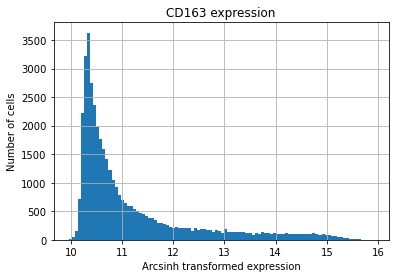

In [47]:
# INPUT: channel name or index channels array
channel = channels[0]
# channel = 'CD163'

dapi_gated_df[channel].hist(bins=100)
plt.title(channel + " expression")
plt.xlabel('Arcsinh transformed expression')
plt.ylabel('Number of cells')
plt.show()

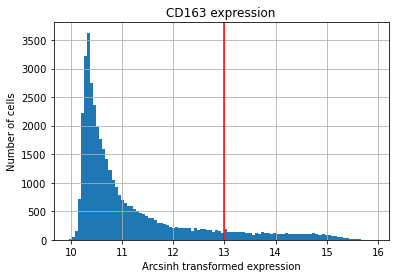

In [78]:
# INPUT: change the gating value
gate = 13

dapi_gated_df[channel].hist(bins=100)
plt.title(channel + " expression")
plt.xlabel('Arcsinh transformed expression')
plt.ylabel('Number of cells')

plt.axvline(x=gate,c=[1,0,0])
plt.show()

with open(log_file_path, 'a') as f:
    line = dt.now().strftime('%Y-%m-%d %H:%M') + ": "+channel+" gate set to "+str(gate)+"\n"
    f.write(line)

In [79]:
channel_dir = Path(exp_dir,channel)
fovs = [f for f in channel_dir.iterdir()]

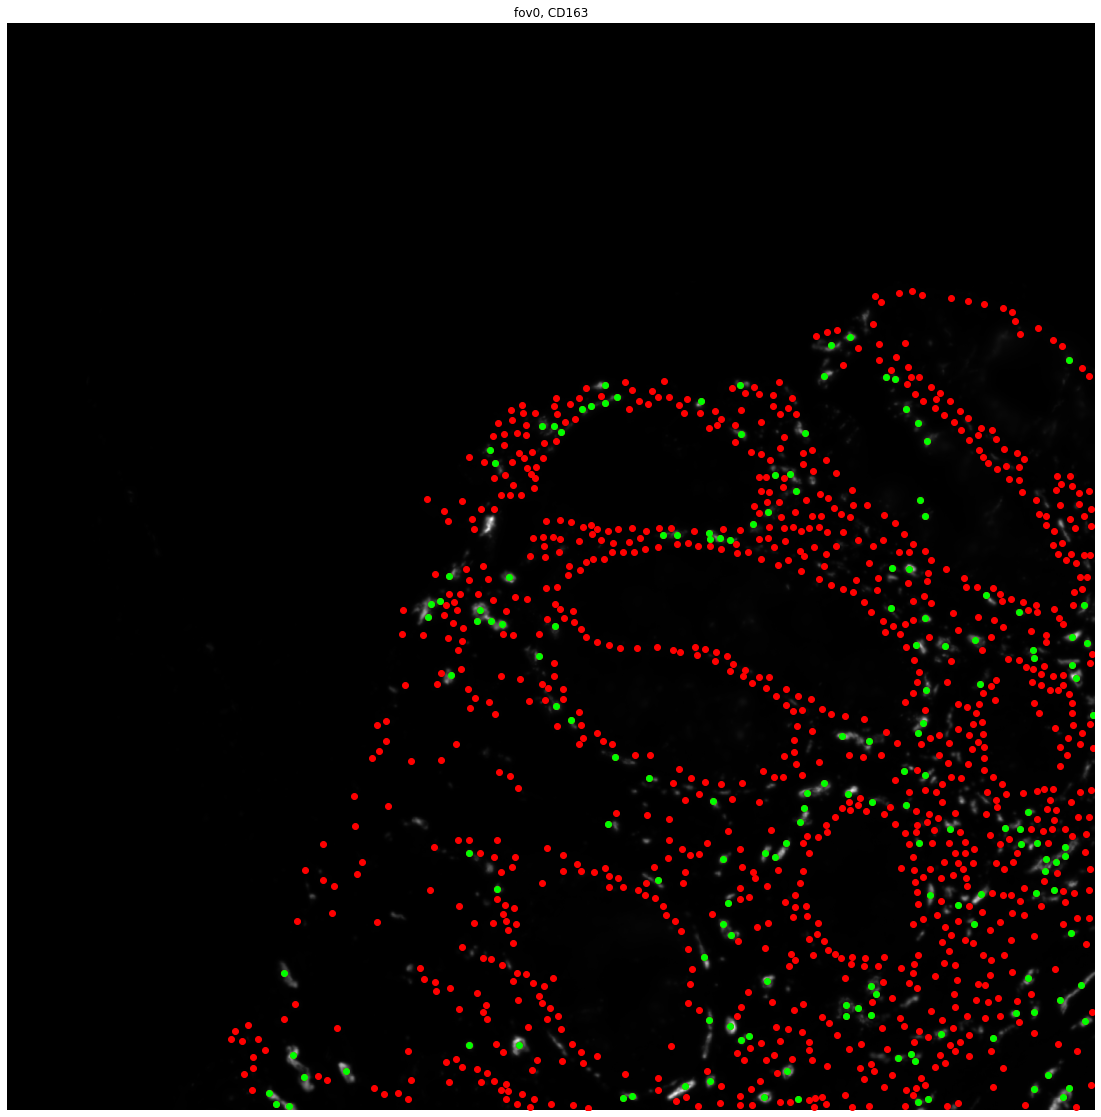

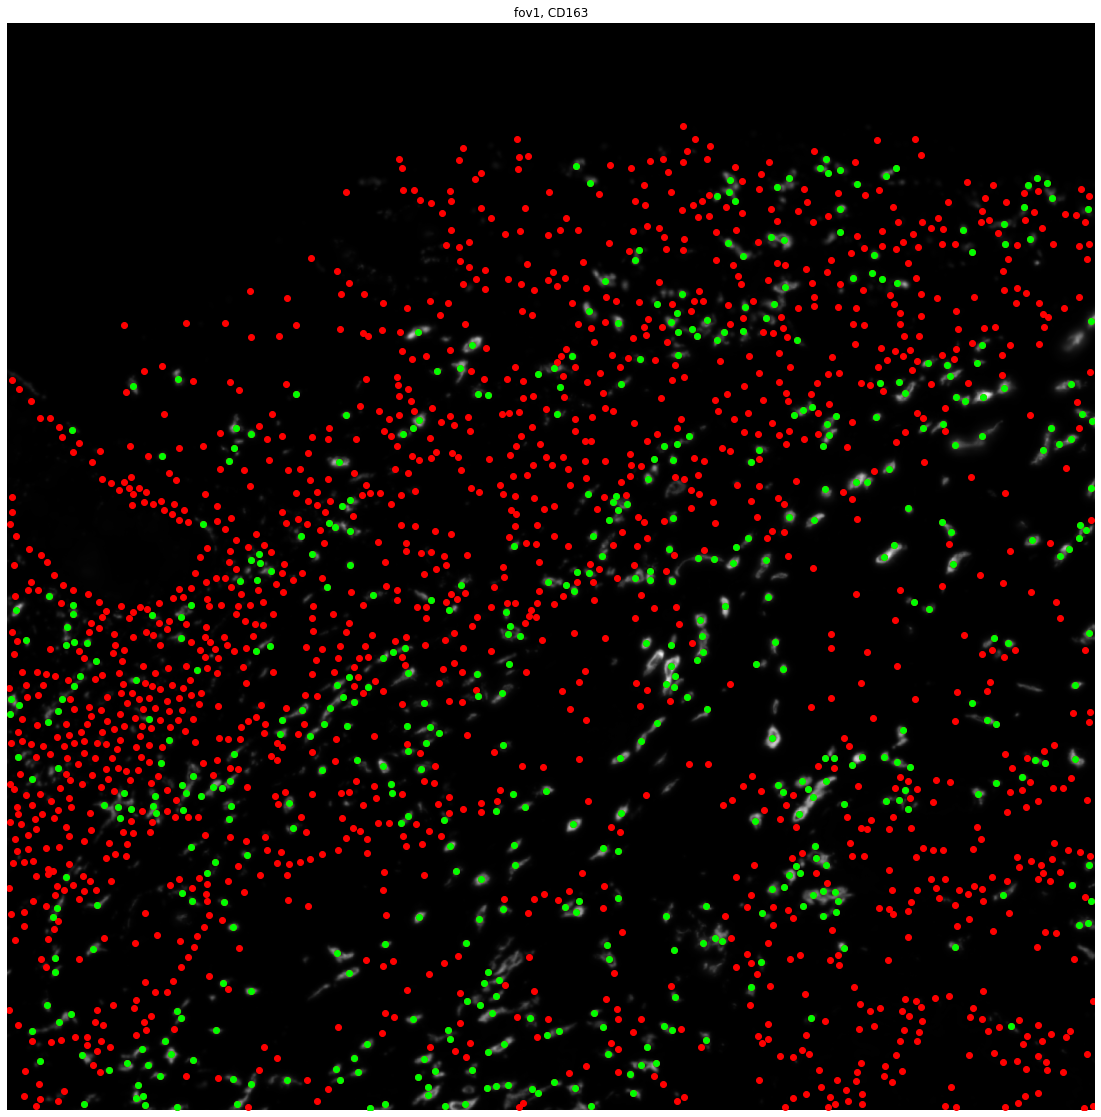

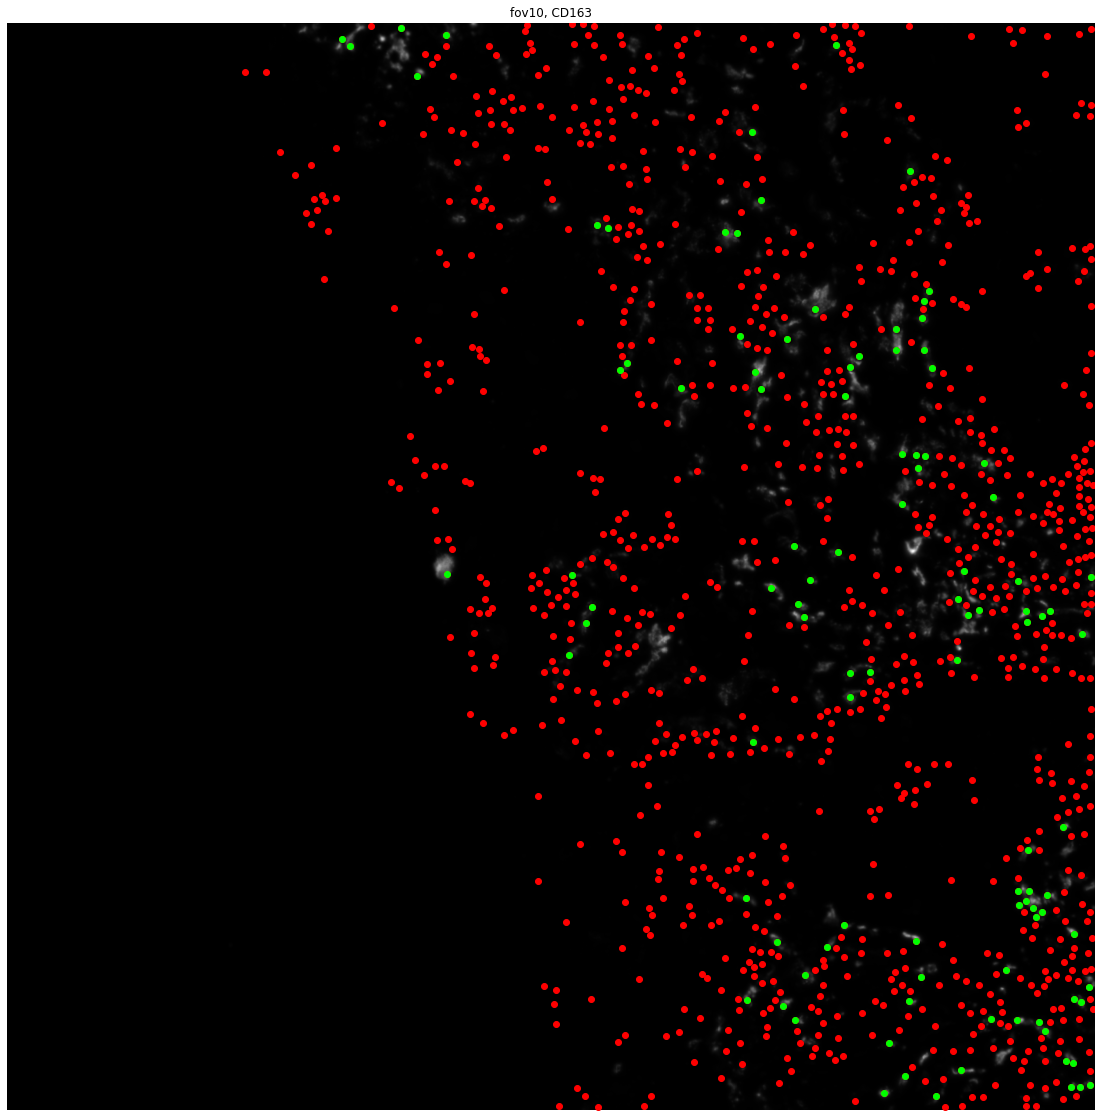

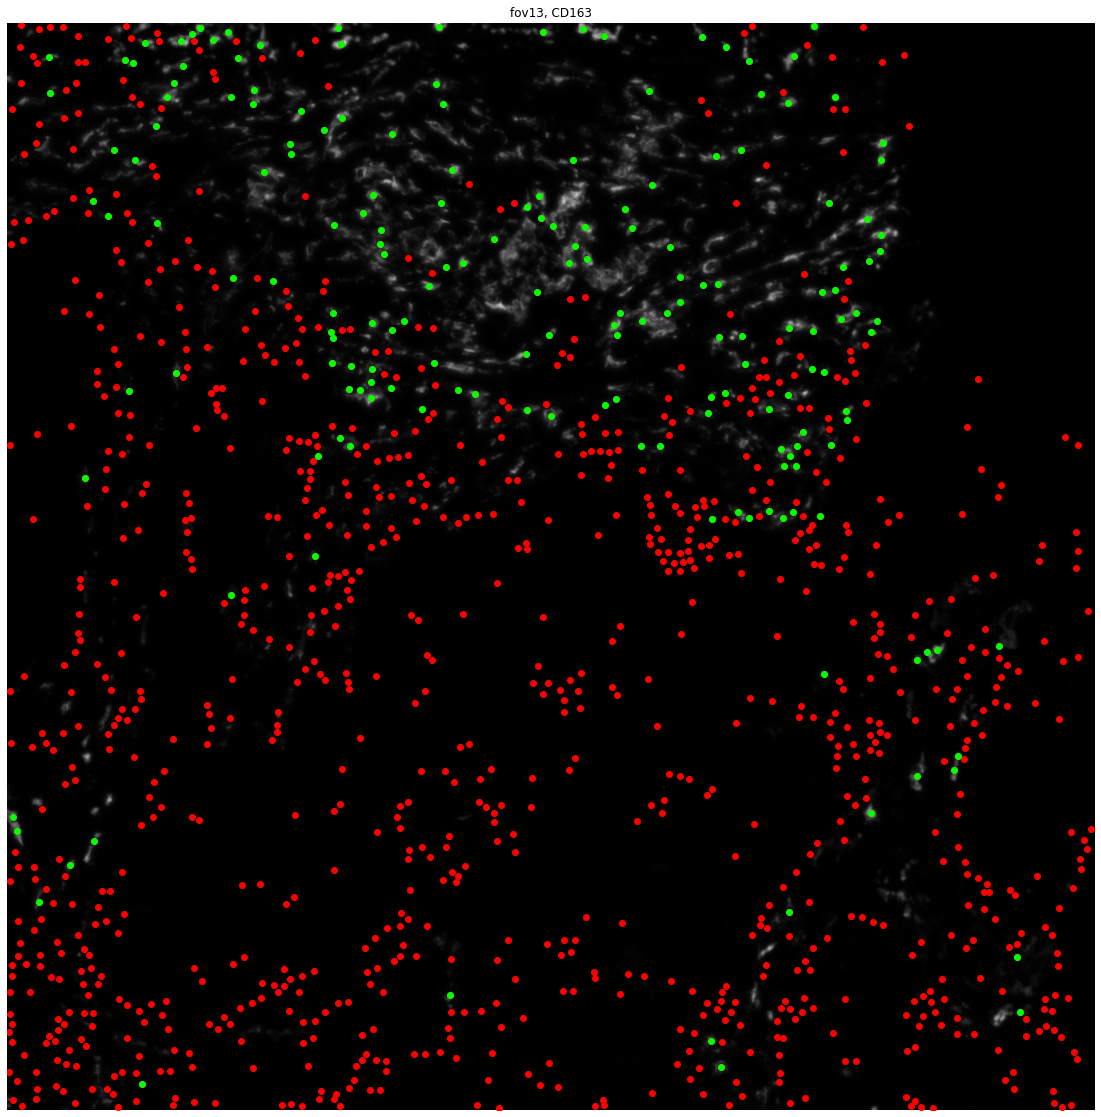

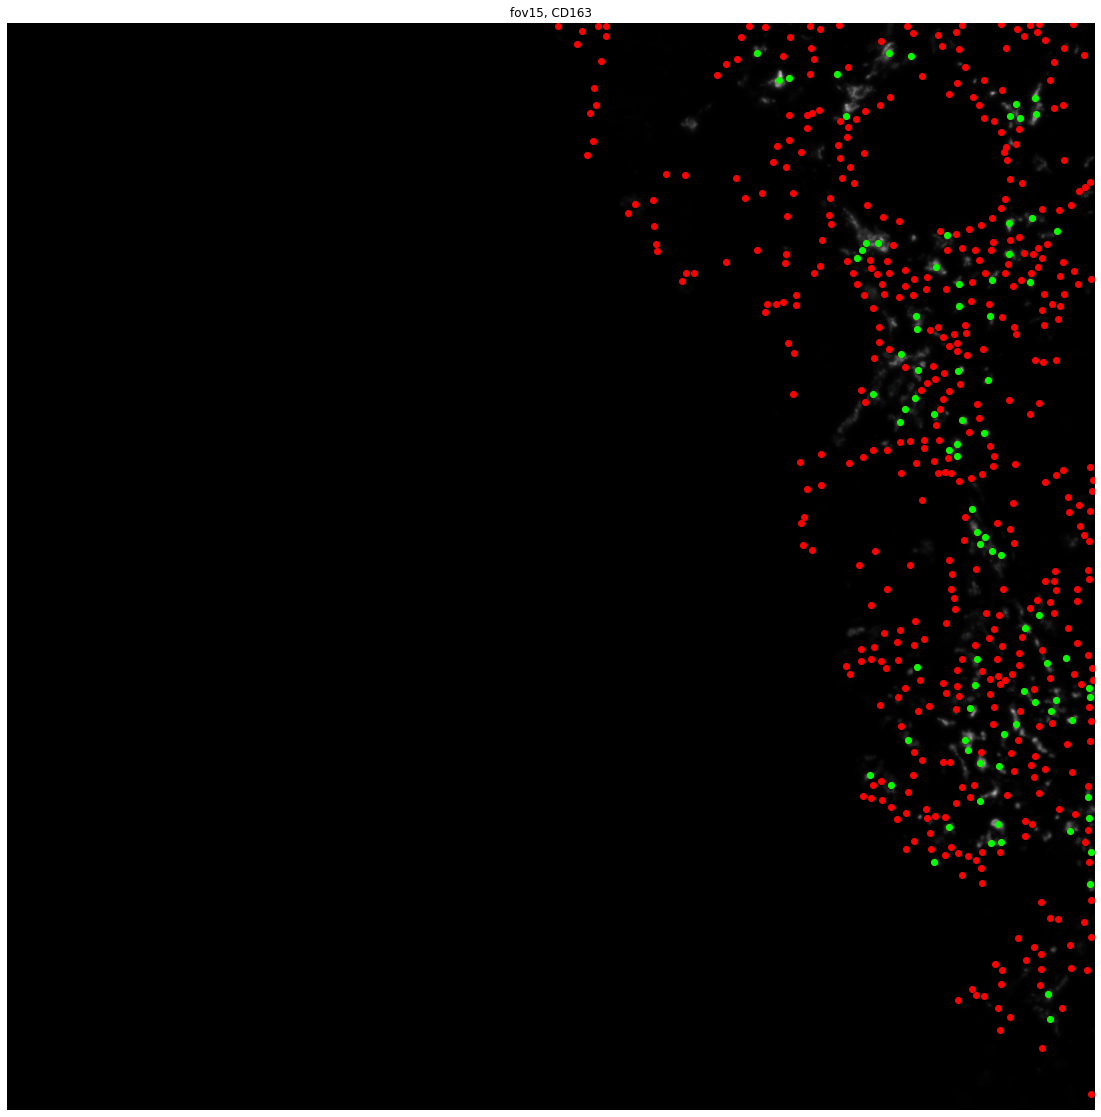

In [80]:
# Number of fovs you want to see (max = 10)
n_fovs = 5

for fov in fovs[0:n_fovs]:
    
    image = tf.TiffFile(fov).asarray()
    
    name = fov.name[:-5]
    x_low,x_hi,y_low,y_hi = tile_pos_data.loc[name]
    
    gating_df = dapi_gated_df.copy()
    
    gating_df = gating_df[gating_df['centroid-0']<x_hi]
    gating_df = gating_df[gating_df['centroid-0']>x_low]
    gating_df = gating_df[gating_df['centroid-1']<y_hi]
    gating_df = gating_df[gating_df['centroid-1']>y_low]
    
    pos = gating_df[gating_df[channel]>gate]
    
    f = plt.figure(figsize=(20,20))
    plt.axis('off')
    
    plt.imshow(image,cmap='gray')
    
    plt.scatter(gating_df['centroid-1'].values-y_low, gating_df['centroid-0'].values-x_low,color=[1,0,0])
    plt.scatter(pos['centroid-1'].values-y_low, pos['centroid-0'].values-x_low,color=[0,1,0])
    
    plt.title(name + ", " + channel)
    
    plt.show()

In [86]:
tf = dapi_gated_df[channel]>gate
dapi_gated_df[channel + "_phenotype"] = tf.astype('int').values

dapi_gated_df.to_csv(save_filepath)